# Gene-Based scRNA

Based off of [the scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

___
Requirements: Uses python 3.

___
Data:

10x Genomics PBMCs: Go to their [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/). Click on any link and download the “Gene / cell matrix (filtered)” file. We tried both the "3k PBMCs from a Healthy Donor" and the "33k PBMCs from a Healthy Donor" datasets.

COVID datasets: From the [Sungnak et al. paper](https://arxiv.org/pdf/2003.06122.pdf), we used the [COVID 19 Cell Atlas](https://www.covid19cellatlas.org/). In particular, the Braga [nasal](https://www.covid19cellatlas.org/#vieira19-nasal) and [lung](https://www.covid19cellatlas.org/?fbclid=IwAR2n0ULjtwresp0caYErWgcLevzj8sBTQ1NZ2qCX_WHtpOv5gzwSLS6j6Cw#vieira19-alveoli) datasets (in h5ad format).


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0


#### Note: you may have to reformat your downloaded file paths to fit below.

In [4]:
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/3k/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

### Read covid data:
# lungFilename = "./data/vieira19_Alveoli_and_parenchyma_anonymised.processed.h5ad"
# nasalFilename = "./data/vieira19_Nasal_anonymised.processed.h5ad"
# adata = covidData = sc.read_h5ad(nasalFilename) #

... writing an h5ad cache file to speedup reading next time


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

In [7]:
#### Do everything in one function:
def runEverything(adata, geneBased):
    """
    Run everything in one go.

    Args:
        adata (scanpy object): The single cell data to analyze.
        geneBased (bool): If you want to flip the matrix and run gene-based instead
            of cell-based. If so, we transpose after all the processing, before the clustering.

    Returns:
        adata (scanpy object): The processed single cell data.
    """
    
    ## First filtering:
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    ## Mito filtering:
    mito_genes = adata.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    adata = adata[adata.obs.n_genes < 2500, :]
    adata = adata[adata.obs.percent_mito < 0.05, :]
    
    ## Total-count normalize:
    sc.pp.normalize_total(adata, target_sum=1e4)
    ## Logarithmize:
    sc.pp.log1p(adata)
    adata.raw = adata
    
    ### If the user wants to do gene-based instead of cell-based:
    ## Doing it here means that we only keep highly-variable cells.
#     if geneBased:
#         adata = adata.transpose()
            
    
    ## Get highly-variable genes. This part probably needs manual input - the plot should be checked.
    sc.pp.highly_variable_genes(adata, min_disp=0.5)#, min_mean=0.0125, max_mean=3)
    sc.pl.highly_variable_genes(adata)
    ## Keep highly-variable genes:
    adata = adata[:, adata.var.highly_variable]

#     sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    ## https://github.com/theislab/scanpy/issues/230?fbclid=IwAR1JPs8DcssFb-wAZGajo4LuQNASeCEr8CDbxRlVcfmOtPBRLY7l8N_Jnc8
    
    sc.pp.scale(adata, max_value=10)

    ### If the user wants to do gene-based instead of cell-based:
    ## Doing it here means that most genes are removed (since they're not highly variable).
    if geneBased:
        adata = adata.transpose()
        
    ### PCA
    sc.tl.pca(adata, svd_solver='arpack')
    ### Nearest neighbors:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    ### Cluster:
    sc.tl.leiden(adata, resolution = 0.75)
    
    ### Marker genes:
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

    ### Get the {clusters: top marker genes} dict
    clustersToTopGenes = dict(pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0])
    topGenes = list(clustersToTopGenes.values())

    sc.pl.umap(adata, color = ['leiden'] + topGenes)

    return adata


In [ ]:
### To save the cluster labels:
# geneBasedData.obs.to_csv("clusteredNasal.csv")

### This line runs the standard analysis.

filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:02)
extracting highly variable genes


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


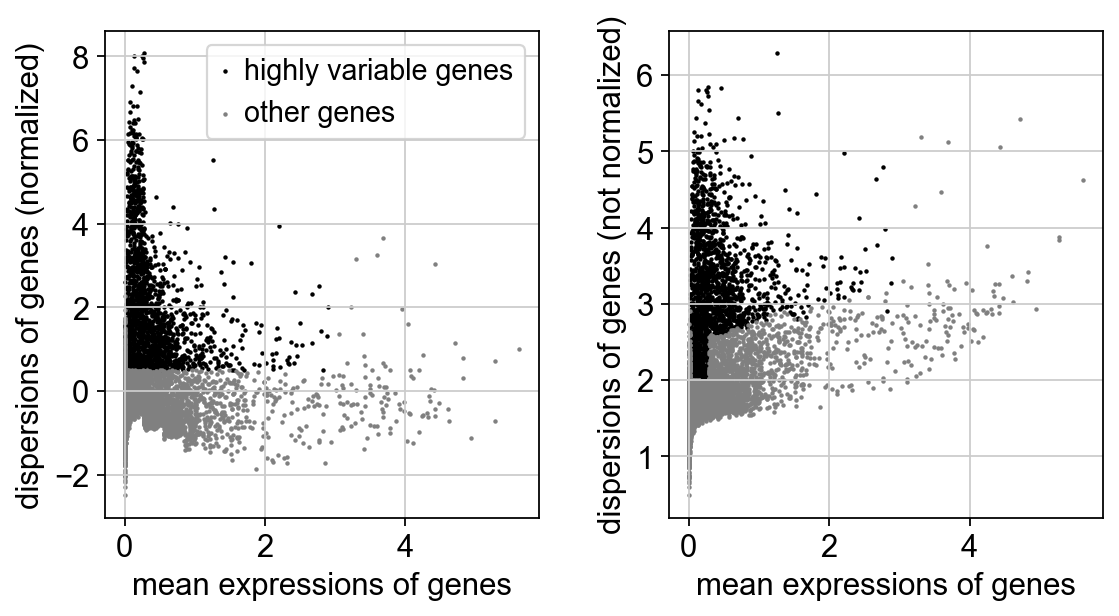

    on highly variable genes
computing PCA with n_comps = 50


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


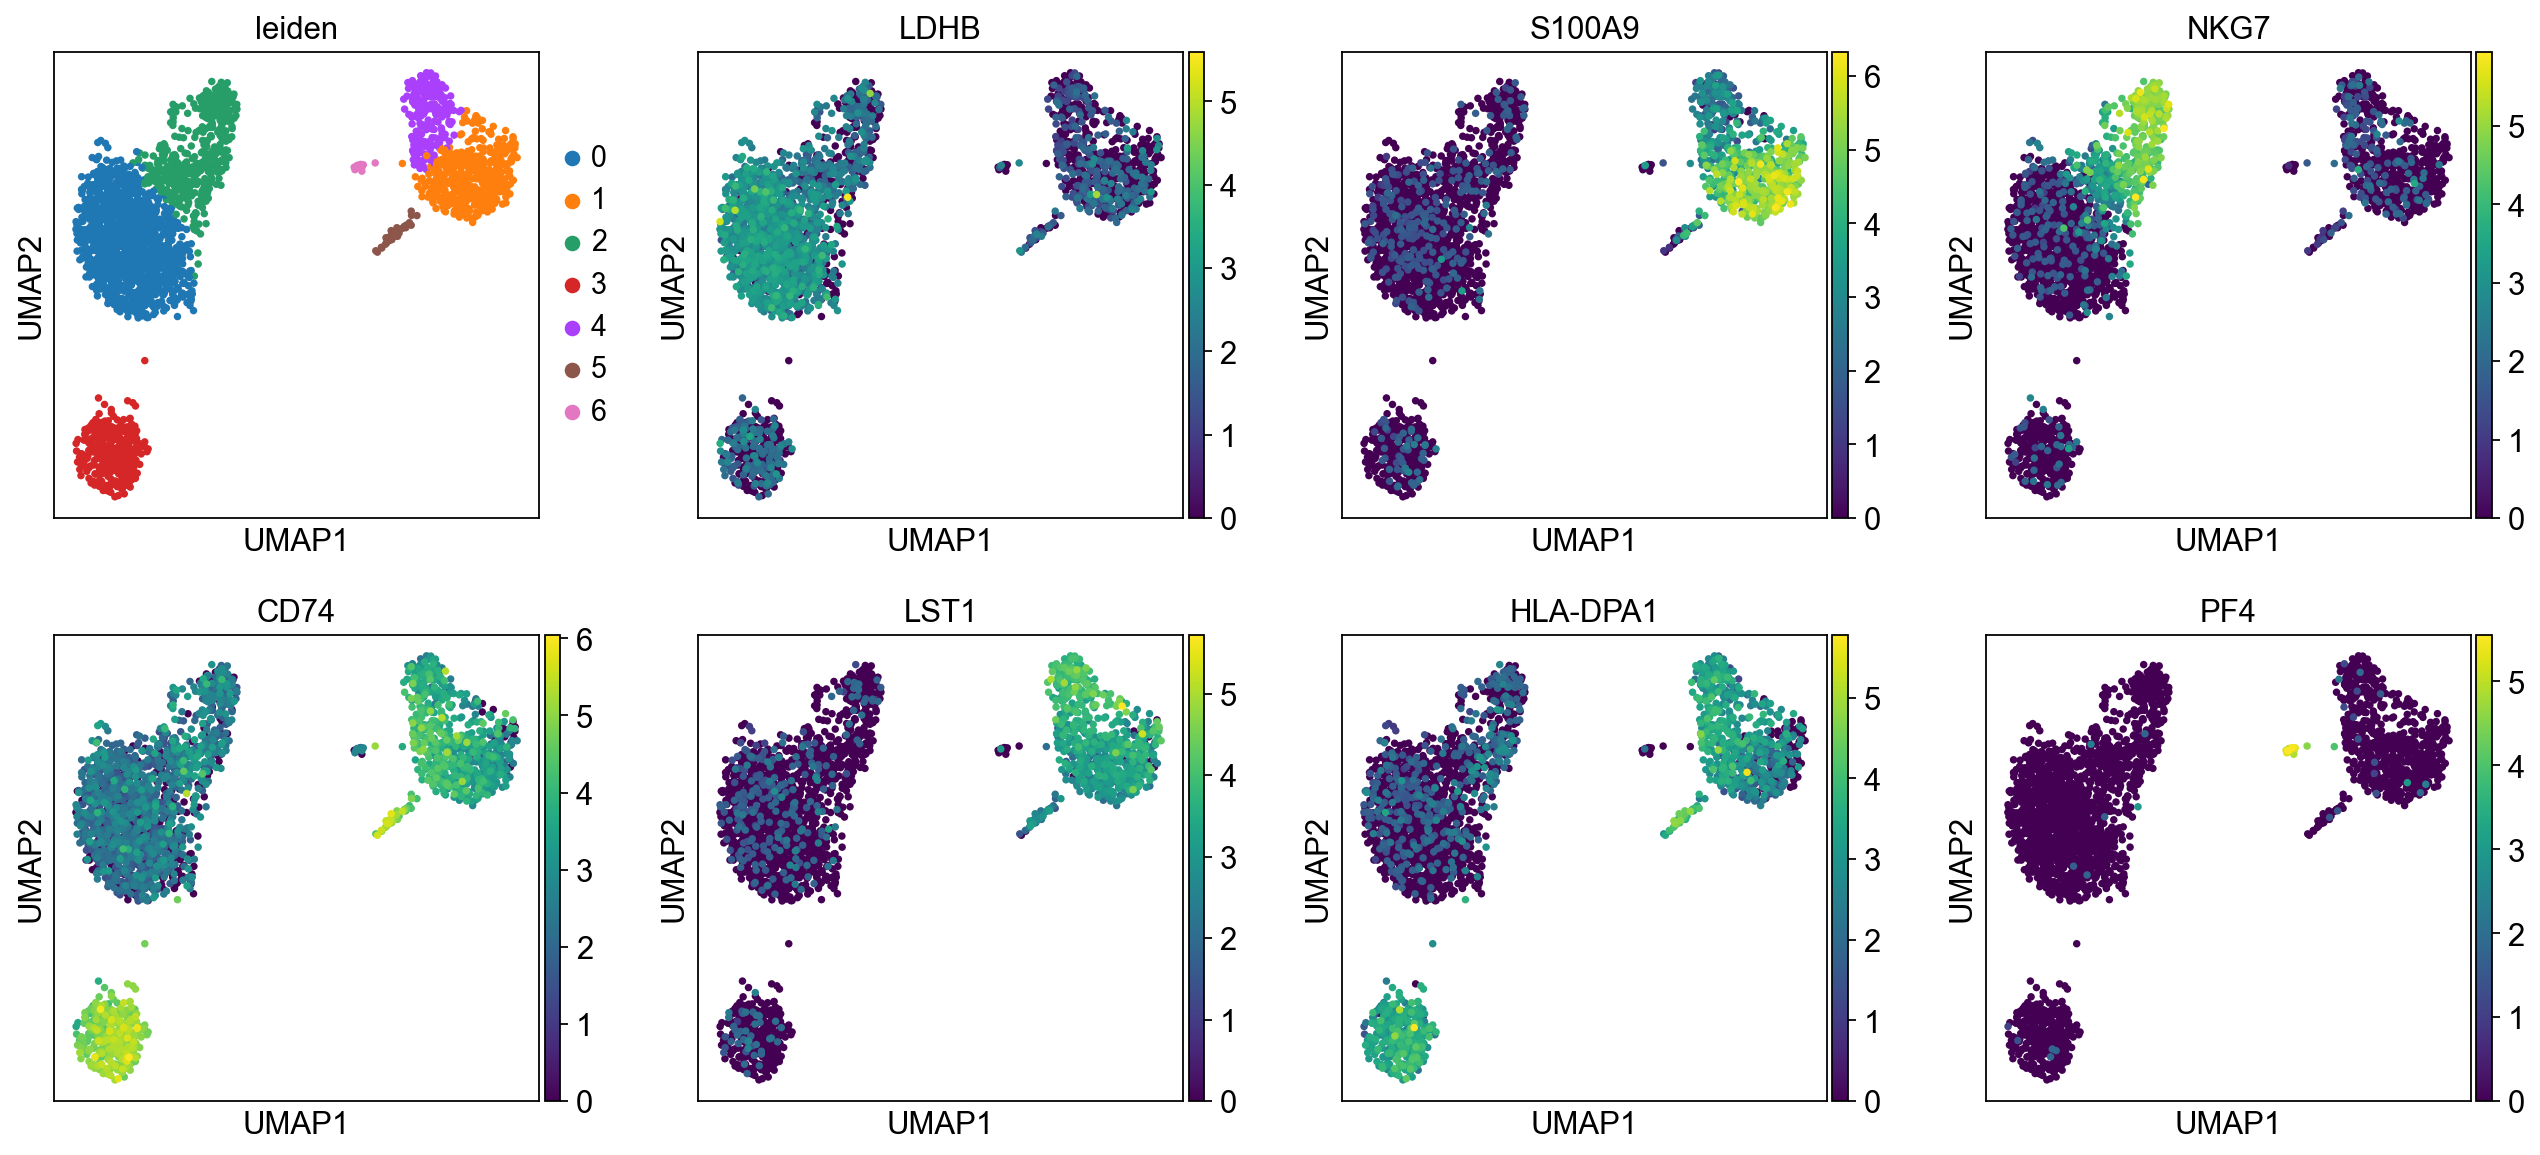

In [8]:
cellBasedData = runEverything(adata, geneBased = False)

### This line runs the gene-based analysis.

normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


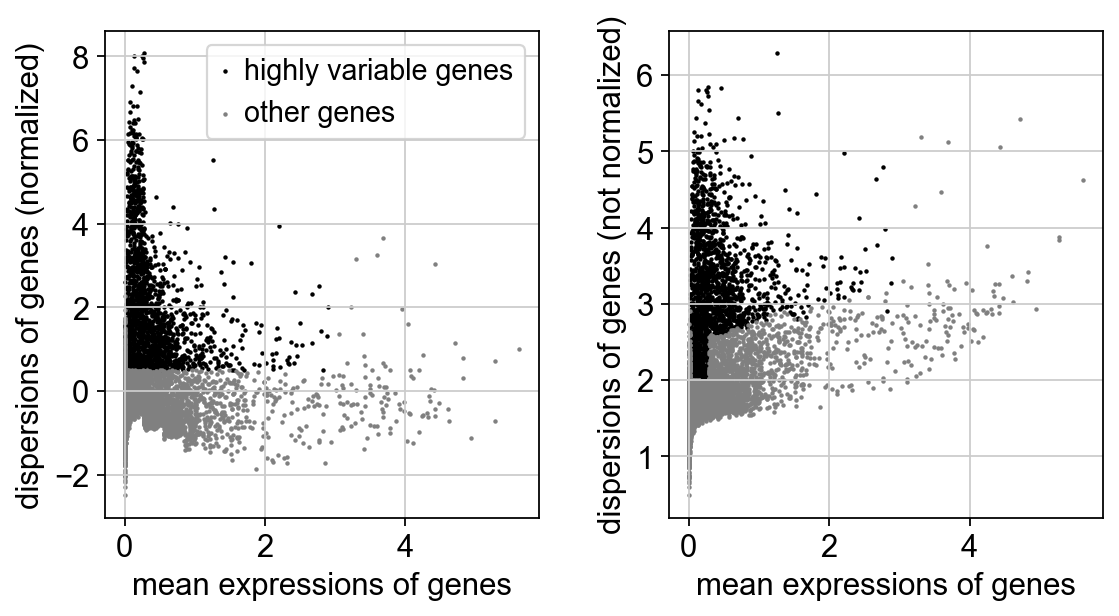

computing PCA with n_comps = 50


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


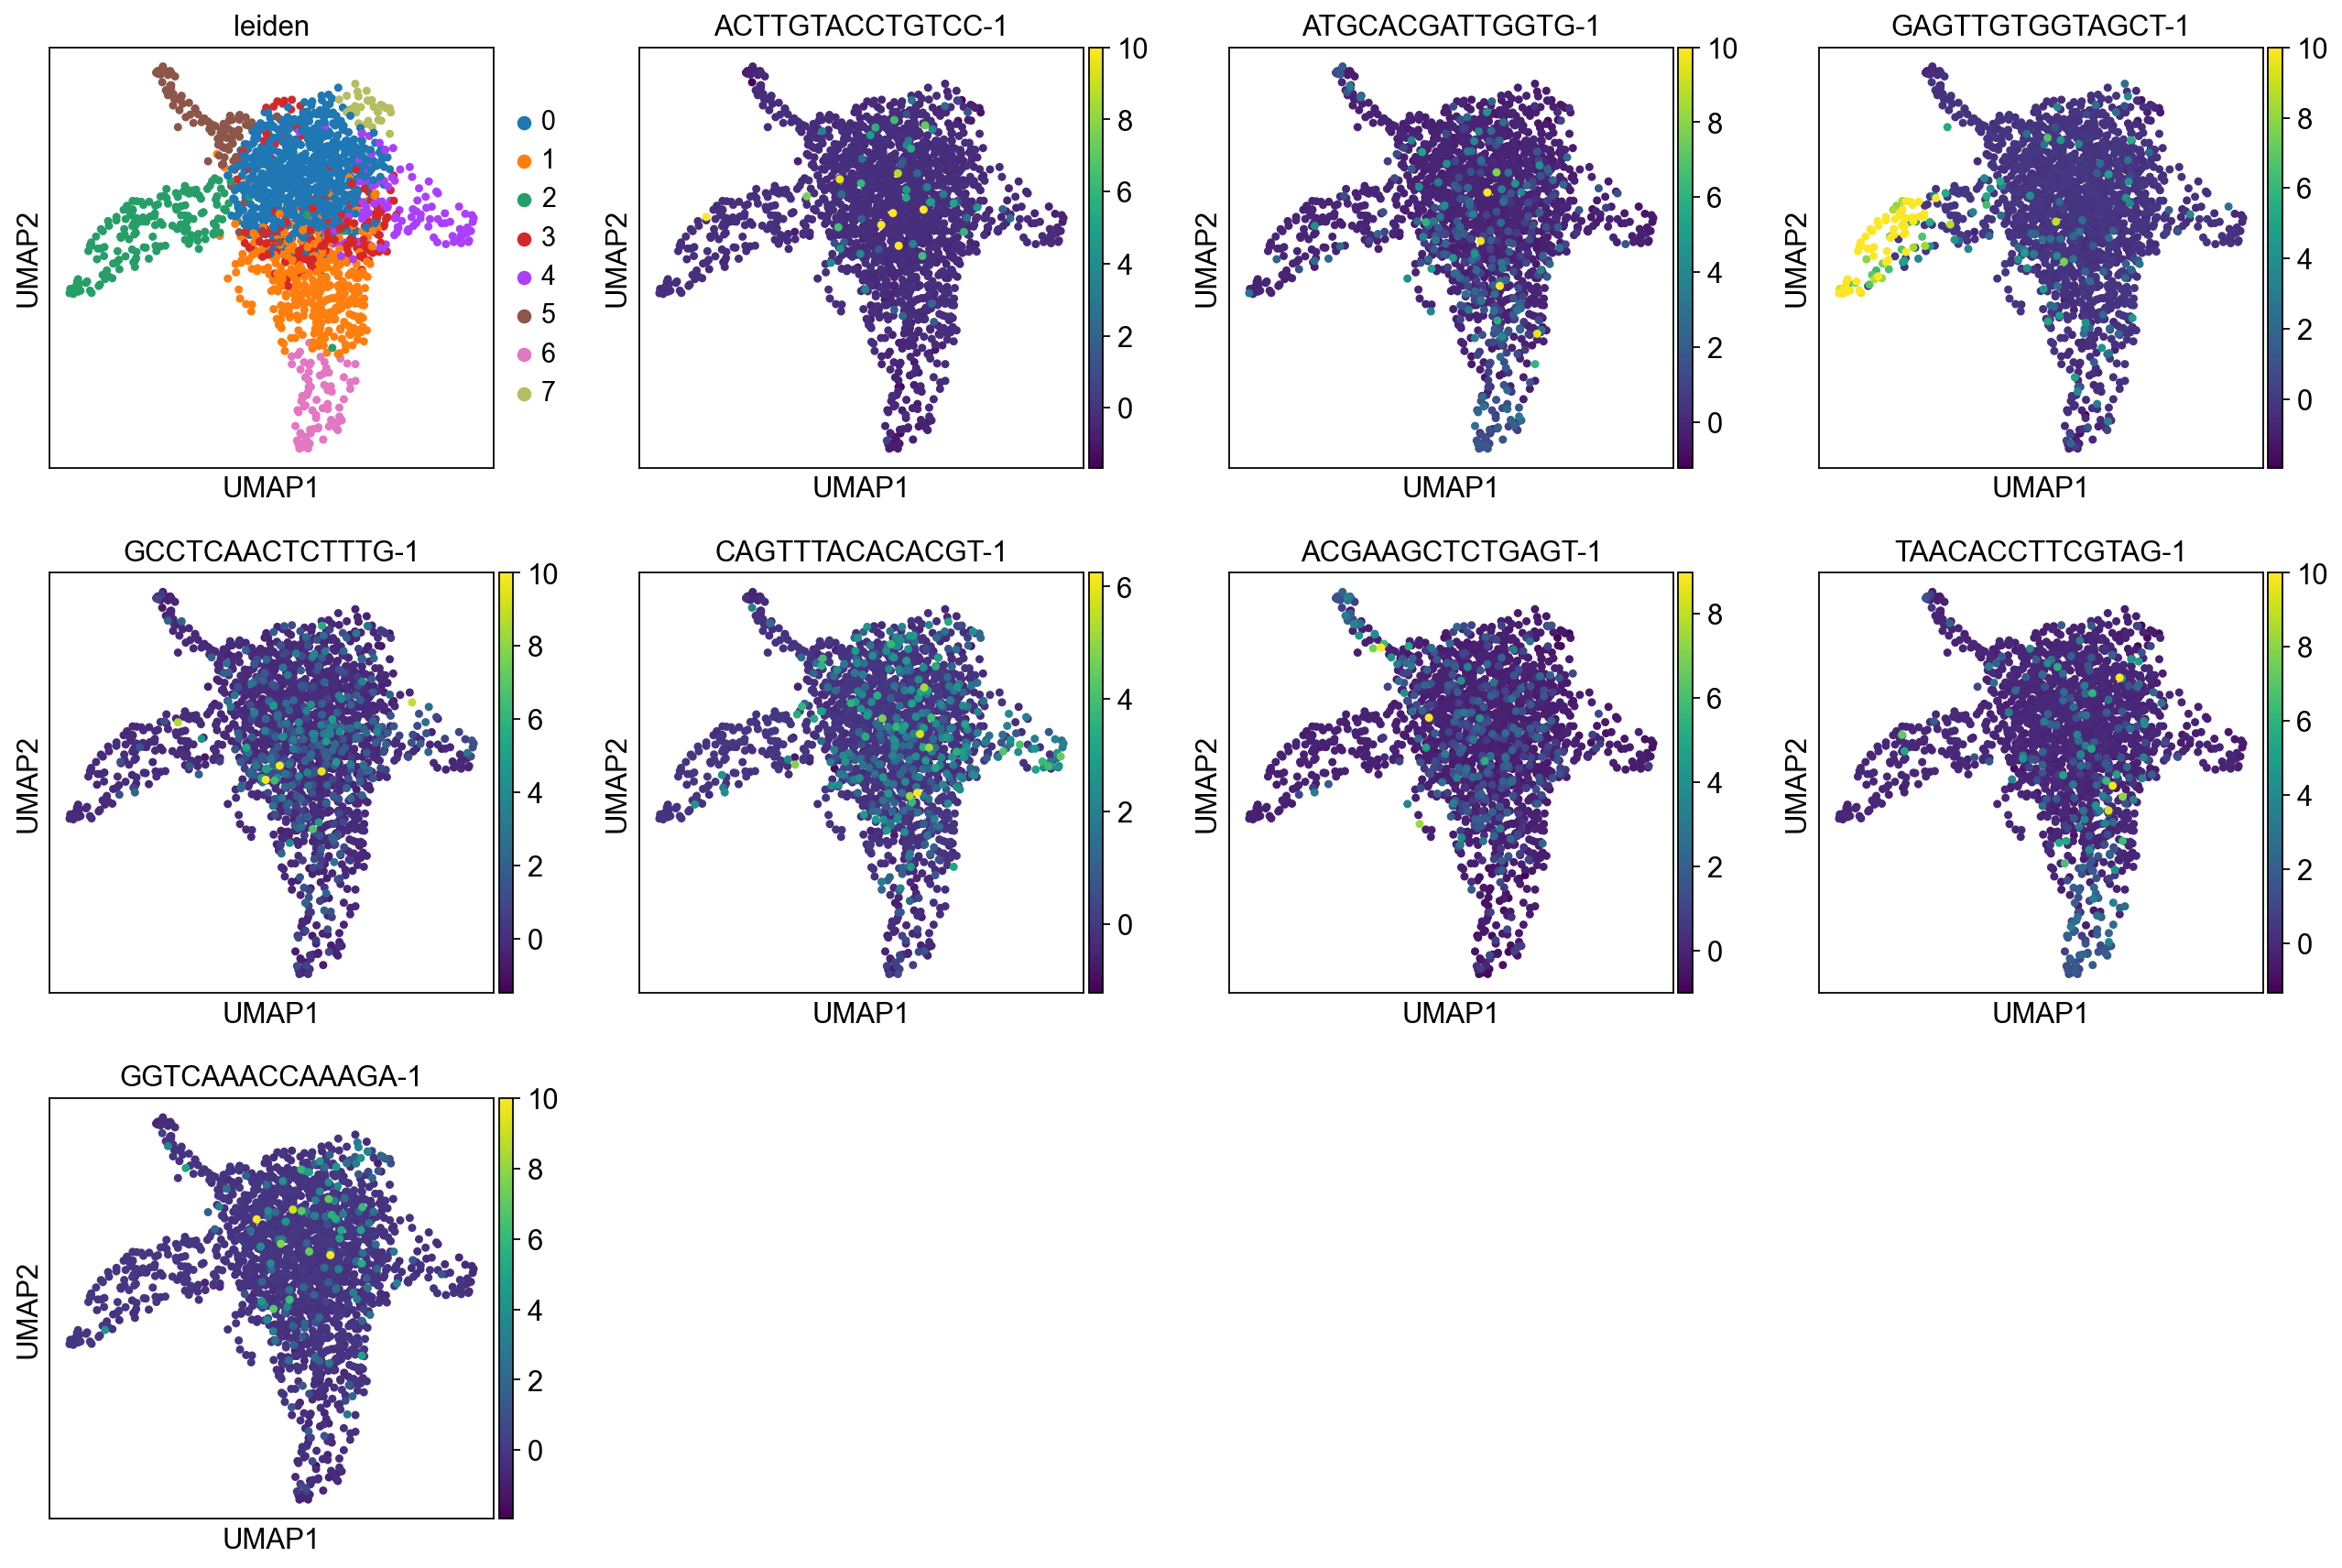

In [9]:
geneBasedData = runEverything(adata, geneBased = True)

### If you have a particular set of objects you'd like to flag in the plot:

In [10]:
def highlightListOfDots(adata, objectsToHighlight):
    """
    Light up a list of dots in a scanpy plot, and make a legend.

    Args:
        adata (scanpy object): The single cell data to analyze.
        objectsToHighlight (list): Either cells or genes
    """    
    numDots = len(geneBasedData.obs.index)
    defaultSize = 120000/numDots
    ### If you want to do separate plots for each:
#     for item in objectsToHighlight:
#         adata.obs[item] = adata.obs_names.isin([item])
#         sizes = pd.Series([300 if dot == item else defaultSize for dot in geneBasedData.obs.index])
#         sc.pl.umap(adata, color=item, size = sizes)
        
    ### Do one big plot:
    dotIndices = [dot if dot in objectsToHighlight else "0" for dot in adata.obs.index]
    sizes = pd.Series([300 if dot in objectsToHighlight else 10 for dot in adata.obs.index])
    alphas = [0.7 if dot in objectsToHighlight else 0.2 for dot in adata.obs.index]

    geneBasedData.obs["Marker Genes"] = dotIndices
    sc.pl.umap(geneBasedData, color=['Marker Genes'], size = sizes, alpha = 0.3)
#     kwargs = {'s': sizes, 'alpha': alphas}
#     sc.pl.umap(geneBasedData, color=['Marker Genes'], **kwargs)

... storing 'Marker Genes' as categorical


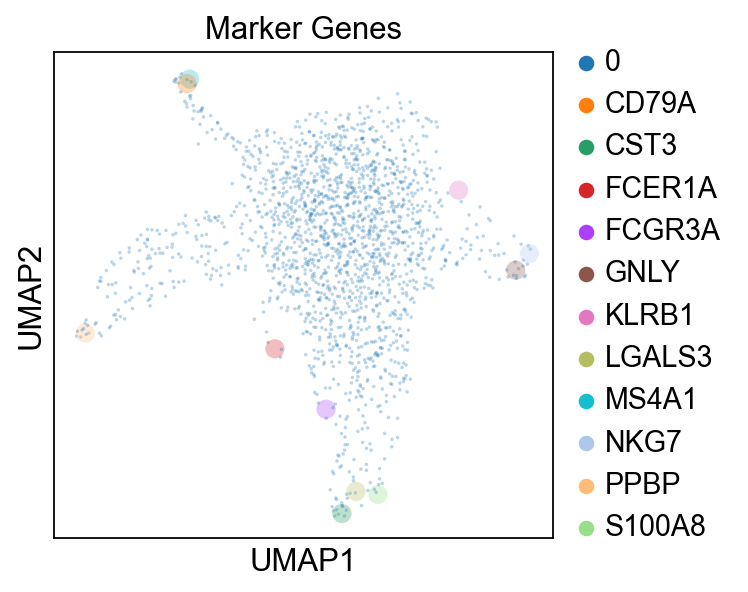

In [11]:
barcodes = ['AAACATACAACCAC-1', 'TTTCTACTTCCTCG-1']
genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14', 'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1', 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
highlightListOfDots(adata = geneBasedData, objectsToHighlight = genes)


### To see the mappings onto different spaces, while showing the Leiden communities:

In [12]:
def plotDifferentTypes(adata):
    sc.tl.tsne(adata)
    sc.pl.pca(adata, color = ['leiden'])
    sc.pl.umap(adata, color = ['leiden'])
    sc.pl.tsne(adata, color = ['leiden'])

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:13)


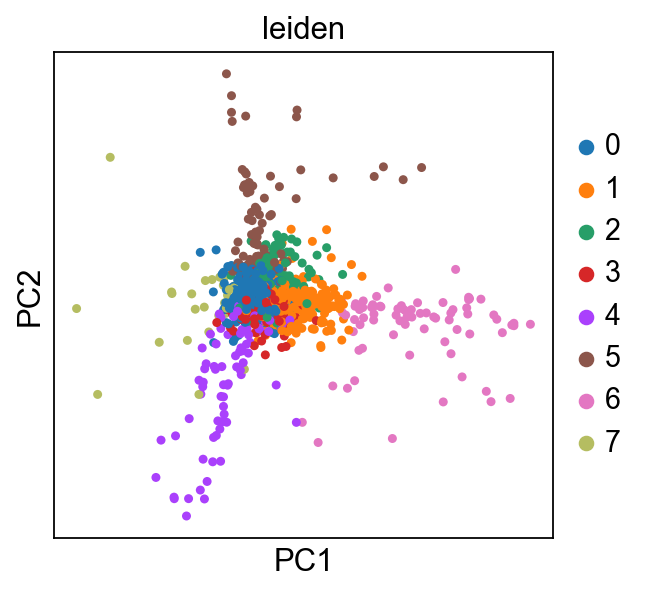

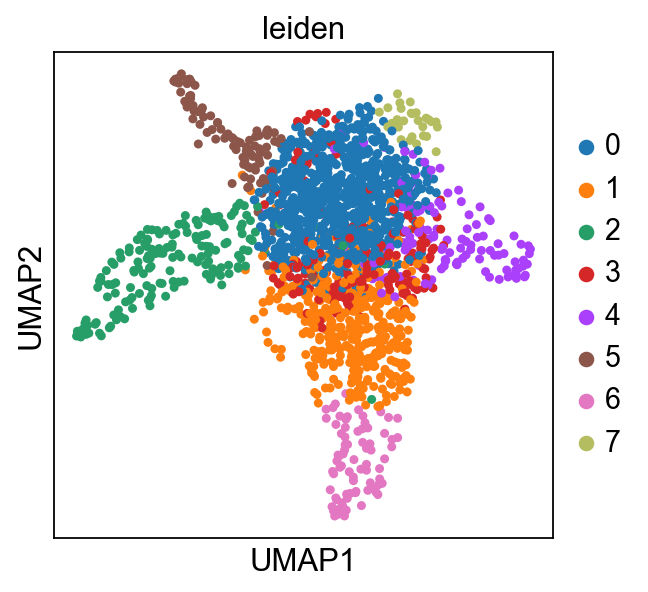

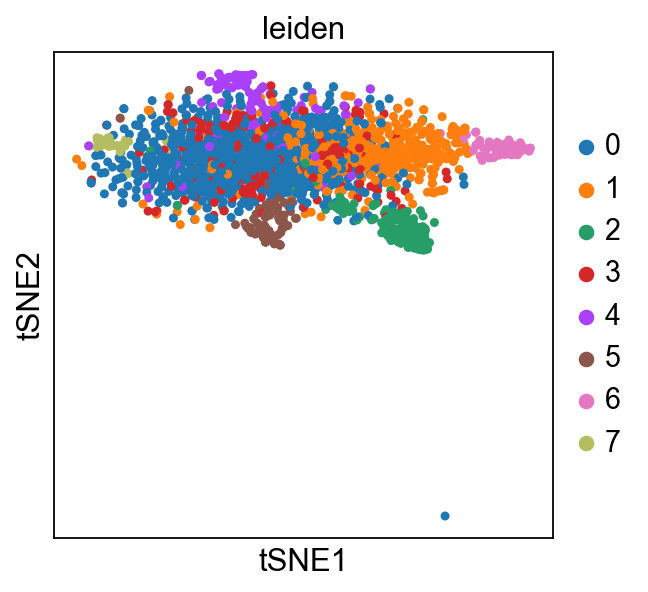

In [13]:
plotDifferentTypes(geneBasedData)

### Nearest neighbors of a particular gene, for investigation:

... storing 'Marker Genes' as categorical


Neighbors: Index(['RNF113A', 'CST3'], dtype='object')


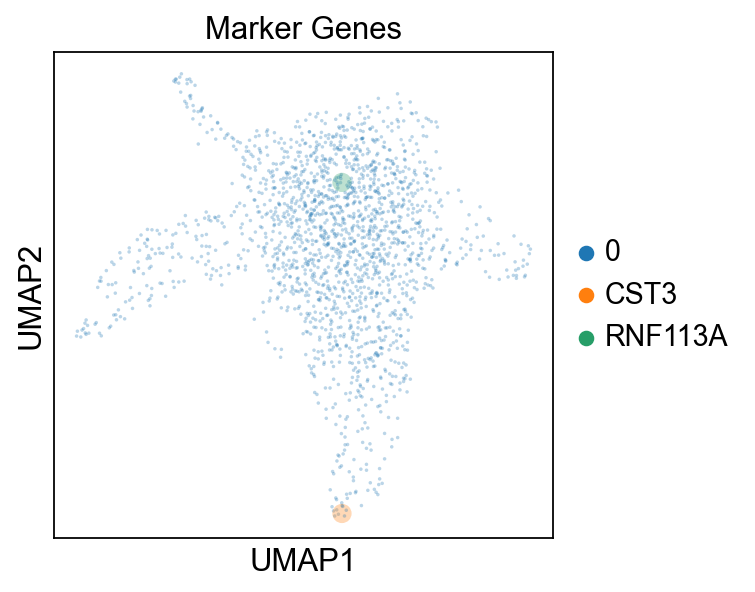

In [16]:
# geneBasedData.obsm["X_umap"]
gene = "CST3"
dotIndex = [True if dot in [gene] else False for dot in geneBasedData.obs.index]
adata.obs[gene] = adata.obs_names.isin([gene])
genesUMAPcoords = geneBasedData.obsm["X_umap"][dotIndex]
x, y = genesUMAPcoords[0]
window = 0.002
xUpper = x + window
xLower = x - window
yUpper = y + window
yLower = y - window
umapXs = pd.Series(geneBasedData.obsm["X_umap"][:, 0])
umapYs = pd.Series(geneBasedData.obsm["X_umap"][:, 1])
isNeighbor = umapXs.between(xLower, xUpper) | umapYs.between(yLower, yUpper)

### Use all PCs:
# window = 0.02
# pcs = geneBasedData.obsm["PCs"][dotIndex][0]
# isNeighbor = pd.Series([False]*len(geneBasedData.obs.index))
# for index, pc in enumerate(pcs):
#     upper = pc + window
#     lower = pc - window
#     pcsAtThisIndex = pd.Series(geneBasedData.obsm["PCs"][:, index])
# #     print (pc, index, len(isNeighbor), len(pcsAtThisIndex))
#     isNeighbor |= pcsAtThisIndex.between(lower, upper)

print ("Neighbors:", geneBasedData.obs.index[isNeighbor])
if len(geneBasedData.obs.index[isNeighbor]) < 20:
    highlightListOfDots(adata = geneBasedData, objectsToHighlight = geneBasedData.obs.index[isNeighbor])
else:
    print("You've got too many neighbors to plot.")


# Autoencoder

Working from [this post](https://towardsdatascience.com/deep-learning-for-single-cell-biology-935d45064438).

In [18]:
import numpy as np
import pandas as pd
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
import scanpy as sc

autoencoderData = adata

expr = pd.DataFrame.sparse.from_spmatrix(autoencoderData.X)

Using TensorFlow backend.


In [19]:
X = expr.values[:,0:expr.shape[1]]
X = np.log(X + 1)

In [38]:
file = pd.read_csv("output.csv")
expr[1838]=file['leiden']
Y = expr.values[:,expr.shape[1]-1]  ## Just to light up points on graphs

(2638, 1838)

In [44]:
Y = expr.values[:,expr.shape[1]-1]

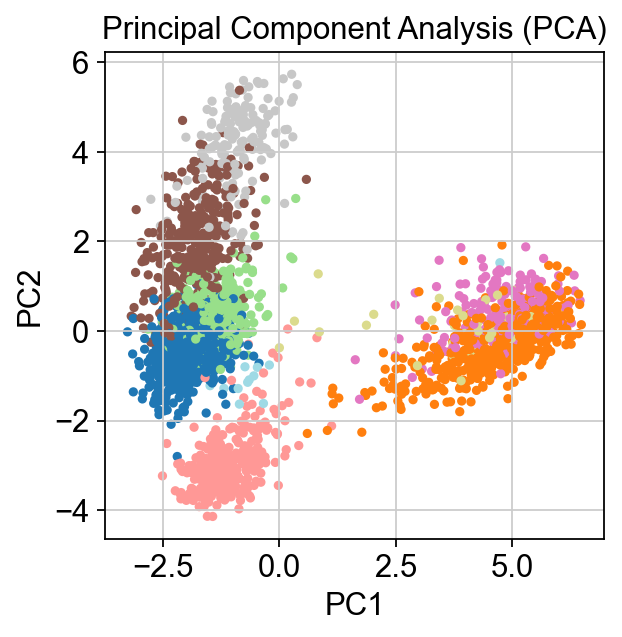

Epoch 1/500
2638/2638 [==============================] - 1s 365us/step - loss: 0.8622
Epoch 2/500
2638/2638 [==============================] - 0s 37us/step - loss: 0.8233
Epoch 3/500
2638/2638 [==============================] - 0s 39us/step - loss: 0.7527
Epoch 4/500
2638/2638 [==============================] - 0s 41us/step - loss: 0.6591
Epoch 5/500
2638/2638 [==============================] - 0s 46us/step - loss: 0.6176
Epoch 6/500
2638/2638 [==============================] - 0s 52us/step - loss: 0.5891
Epoch 7/500
2638/2638 [==============================] - 0s 44us/step - loss: 0.5715
Epoch 8/500
2638/2638 [==============================] - 0s 47us/step - loss: 0.5645
Epoch 9/500
2638/2638 [==============================] - 0s 42us/step - loss: 0.5608
Epoch 10/500
2638/2638 [==============================] - 0s 41us/step - loss: 0.5582
Epoch 11/500
2638/2638 [==============================] - 0s 40us/step - loss: 0.5563
Epoch 12/500
2638/2638 [==============================] - 0s 4

2638/2638 [==============================] - 0s 42us/step - loss: 0.5338
Epoch 191/500
2638/2638 [==============================] - 0s 49us/step - loss: 0.5338
Epoch 192/500
2638/2638 [==============================] - 0s 33us/step - loss: 0.5337
Epoch 193/500
2638/2638 [==============================] - 0s 34us/step - loss: 0.5337
Epoch 194/500
2638/2638 [==============================] - 0s 33us/step - loss: 0.5336
Epoch 195/500
2638/2638 [==============================] - 0s 35us/step - loss: 0.5336
Epoch 196/500
2638/2638 [==============================] - 0s 34us/step - loss: 0.5336
Epoch 197/500
2638/2638 [==============================] - 0s 36us/step - loss: 0.5336
Epoch 198/500
2638/2638 [==============================] - 0s 41us/step - loss: 0.5335
Epoch 199/500
2638/2638 [==============================] - 0s 41us/step - loss: 0.5335
Epoch 200/500
2638/2638 [==============================] - 0s 50us/step - loss: 0.5335
Epoch 201/500
2638/2638 [==============================] 

2638/2638 [==============================] - 0s 49us/step - loss: 0.5316
Epoch 285/500
2638/2638 [==============================] - 0s 50us/step - loss: 0.5316
Epoch 286/500
2638/2638 [==============================] - 0s 41us/step - loss: 0.5316
Epoch 287/500
2638/2638 [==============================] - 0s 45us/step - loss: 0.5316
Epoch 288/500
2638/2638 [==============================] - 0s 41us/step - loss: 0.5316
Epoch 289/500
2638/2638 [==============================] - 0s 46us/step - loss: 0.5315
Epoch 290/500
2638/2638 [==============================] - 0s 47us/step - loss: 0.5314
Epoch 291/500
2638/2638 [==============================] - 0s 42us/step - loss: 0.5314
Epoch 292/500
2638/2638 [==============================] - 0s 39us/step - loss: 0.5315
Epoch 293/500
2638/2638 [==============================] - 0s 53us/step - loss: 0.5314
Epoch 294/500
2638/2638 [==============================] - 0s 61us/step - loss: 0.5314
Epoch 295/500
2638/2638 [==============================] 

2638/2638 [==============================] - 0s 44us/step - loss: 0.5286
Epoch 473/500
2638/2638 [==============================] - 0s 49us/step - loss: 0.5286
Epoch 474/500
2638/2638 [==============================] - 0s 51us/step - loss: 0.5286
Epoch 475/500
2638/2638 [==============================] - 0s 51us/step - loss: 0.5286
Epoch 476/500
2638/2638 [==============================] - 0s 51us/step - loss: 0.5287
Epoch 477/500
2638/2638 [==============================] - 0s 46us/step - loss: 0.5286
Epoch 478/500
2638/2638 [==============================] - 0s 48us/step - loss: 0.5286
Epoch 479/500
2638/2638 [==============================] - 0s 57us/step - loss: 0.5286: 0s - loss: 0.52
Epoch 480/500
2638/2638 [==============================] - 0s 53us/step - loss: 0.5286
Epoch 481/500
2638/2638 [==============================] - 0s 50us/step - loss: 0.5286
Epoch 482/500
2638/2638 [==============================] - 0s 50us/step - loss: 0.5286
Epoch 483/500
2638/2638 [===============

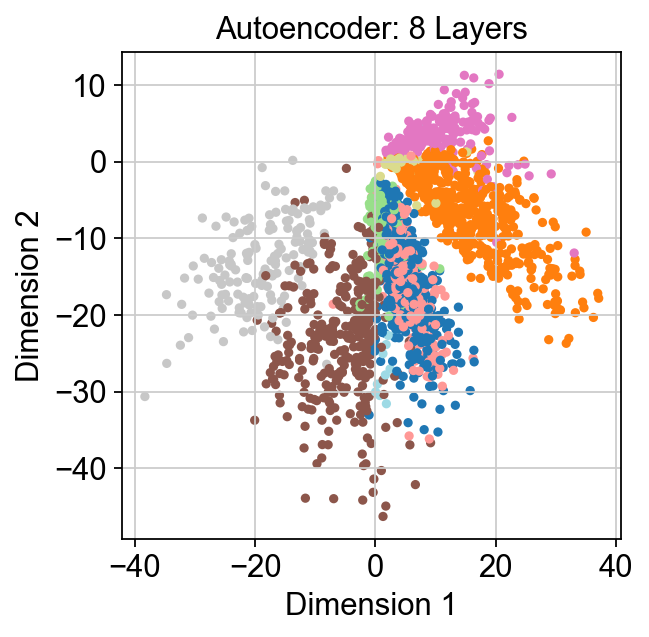

In [45]:
# REDUCE DIMENSIONS WITH PRINCIPAL COMPONENT ANALYSIS (PCA)
n_input = 50
x_train = PCA(n_components = n_input).fit_transform(X); y_train = Y
plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, cmap = 'tab20', s = 10) # c= color
plt.title('Principal Component Analysis (PCA)')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# REDUCE DIMENSIONS WITH AUTOENCODER
model = Sequential()
model.add(Dense(30,       activation='elu', input_shape=(n_input,)))
model.add(Dense(20,       activation='elu'))
model.add(Dense(10,       activation='elu'))
model.add(Dense(2,        activation='linear', name="bottleneck"))
model.add(Dense(10,       activation='elu'))
model.add(Dense(20,       activation='elu'))
model.add(Dense(30,       activation='elu'))
model.add(Dense(n_input,  activation='sigmoid'))
model.compile(loss = 'mean_squared_error', optimizer = Adam())
model.fit(x_train, x_train, batch_size = 128, epochs = 500, verbose = 1)
encoder = Model(model.input, model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(x_train)
plt.scatter(bottleneck_representation[:,0], bottleneck_representation[:,1], 
            c = y_train, s = 10, cmap = 'tab20')
plt.title('Autoencoder: 8 Layers')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

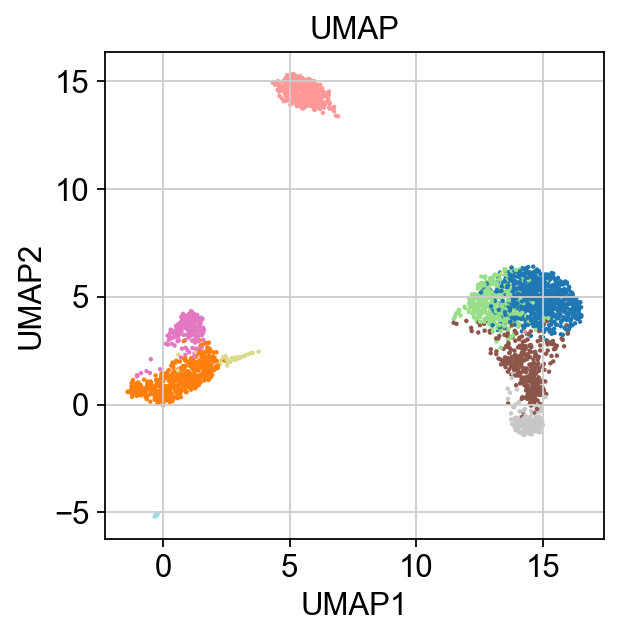

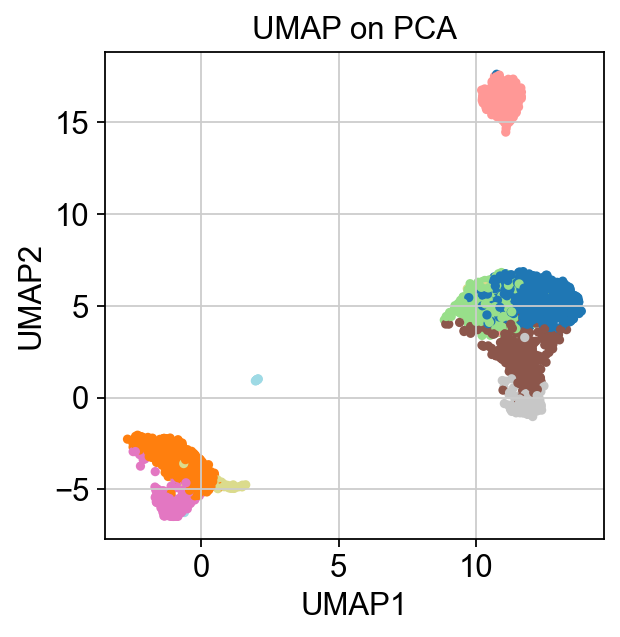

Epoch 1/100
2638/2638 [==============================] - 1s 420us/step - loss: 0.2286
Epoch 2/100
2638/2638 [==============================] - 0s 156us/step - loss: 0.1144
Epoch 3/100
2638/2638 [==============================] - 0s 142us/step - loss: 0.0742
Epoch 4/100
2638/2638 [==============================] - 0s 148us/step - loss: 0.0723
Epoch 5/100
2638/2638 [==============================] - 0s 187us/step - loss: 0.0716 0s - loss: 0.0
Epoch 6/100
2638/2638 [==============================] - 0s 152us/step - loss: 0.0712
Epoch 7/100
2638/2638 [==============================] - 0s 189us/step - loss: 0.0711 0s - loss: 0.071
Epoch 8/100
2638/2638 [==============================] - 0s 141us/step - loss: 0.0709
Epoch 9/100
2638/2638 [==============================] - 0s 141us/step - loss: 0.0708
Epoch 10/100
2638/2638 [==============================] - 0s 176us/step - loss: 0.0706
Epoch 11/100
2638/2638 [==============================] - 0s 175us/step - loss: 0.0705
Epoch 12/100
2638/26

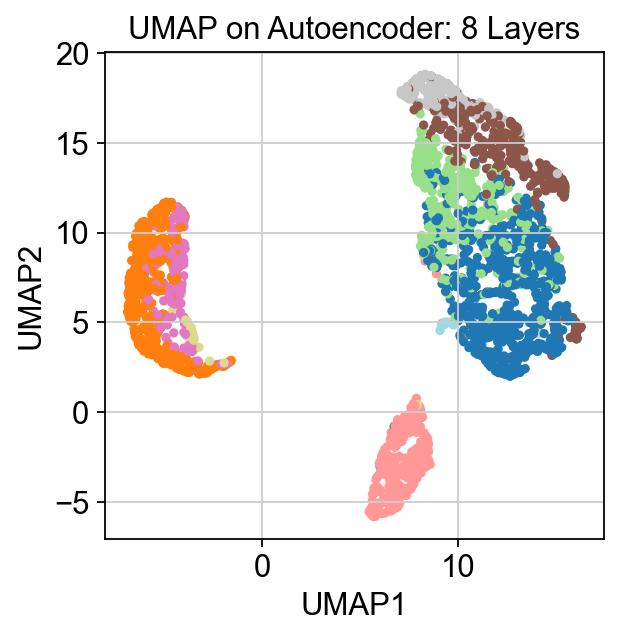

In [49]:
from umap import UMAP

model = UMAP(n_neighbors = 30, min_dist = 0.3, n_components = 2)
umap = model.fit_transform(x_train)
umap_coords = pd.DataFrame({'UMAP1':umap[:, 0], 'UMAP2':umap[:, 1]})
umap_coords.to_csv('umap_coords_10X_1.3M_MouseBrain.txt', sep='\t')
plt.scatter(umap[:, 0], umap[:, 1], c = Y, cmap = 'tab20', s = 1)
plt.title('UMAP')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

# UMAP ON PCA
model_umap = UMAP(n_neighbors = 30, min_dist = 0.3, n_components = 2)
umap = model_umap.fit_transform(x_train)
plt.scatter(umap[:, 0], umap[:, 1], c = y_train, cmap = 'tab20', s = 10)
plt.title('UMAP on PCA')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

# UMAP ON AUTOENCODER
model = Sequential()
model.add(Dense(10,     activation = 'elu', input_shape=(X.shape[1],)))
model.add(Dense(8,      activation = 'elu'))
model.add(Dense(6,      activation = 'elu'))
model.add(Dense(4,      activation = 'linear', name = "bottleneck"))
model.add(Dense(6,      activation = 'elu'))
model.add(Dense(8,      activation = 'elu'))
model.add(Dense(10,     activation = 'elu'))
model.add(Dense(X.shape[1],   activation = 'sigmoid'))
model.compile(loss = 'mean_squared_error', optimizer = Adam())
model.fit(X, X, batch_size = 128, epochs = 100, shuffle = True, verbose = 1)
encoder = Model(model.input, model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(X)

model_umap_auto = UMAP(n_neighbors = 30, min_dist = 0.3, n_components = 2)
umap_auto = model_umap_auto.fit_transform(bottleneck_representation)
plt.scatter(umap_auto[:, 0], umap_auto[:, 1], c = Y, cmap = 'tab20', s = 10)
plt.title('UMAP on Autoencoder: 8 Layers')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 2638 samples in 0.011s...
[t-SNE] Computed neighbors for 2638 samples in 1.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2638
[t-SNE] Computed conditional probabilities for sample 2000 / 2638
[t-SNE] Computed conditional probabilities for sample 2638 / 2638
[t-SNE] Mean sigma: 1.593609
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.997738
[t-SNE] KL divergence after 1000 iterations: 1.470625


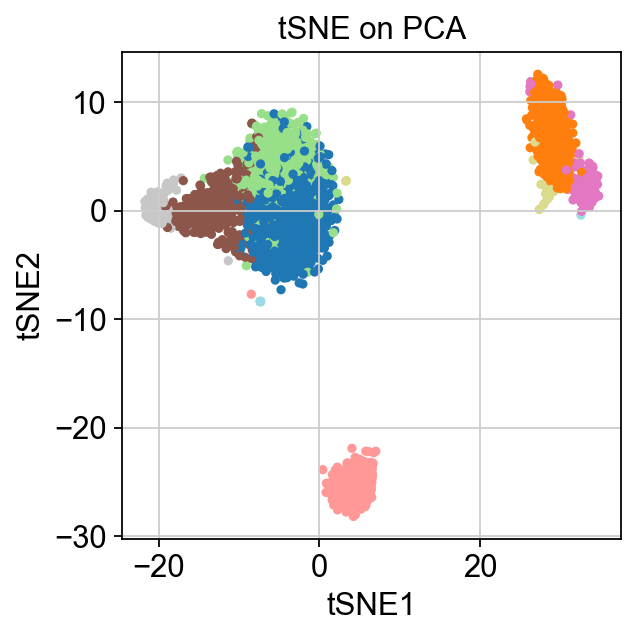

Epoch 1/100
2638/2638 [==============================] - 1s 415us/step - loss: 0.2208
Epoch 2/100
2638/2638 [==============================] - 0s 186us/step - loss: 0.1019
Epoch 3/100
2638/2638 [==============================] - 0s 158us/step - loss: 0.0733
Epoch 4/100
2638/2638 [==============================] - 0s 145us/step - loss: 0.0720
Epoch 5/100
2638/2638 [==============================] - 0s 135us/step - loss: 0.0714
Epoch 6/100
2638/2638 [==============================] - 0s 137us/step - loss: 0.0711
Epoch 7/100
2638/2638 [==============================] - 0s 145us/step - loss: 0.0709
Epoch 8/100
2638/2638 [==============================] - 0s 143us/step - loss: 0.0707
Epoch 9/100
2638/2638 [==============================] - 0s 139us/step - loss: 0.0706
Epoch 10/100
2638/2638 [==============================] - 0s 164us/step - loss: 0.0705
Epoch 11/100
2638/2638 [==============================] - 0s 163us/step - loss: 0.0704
Epoch 12/100
2638/2638 [============================

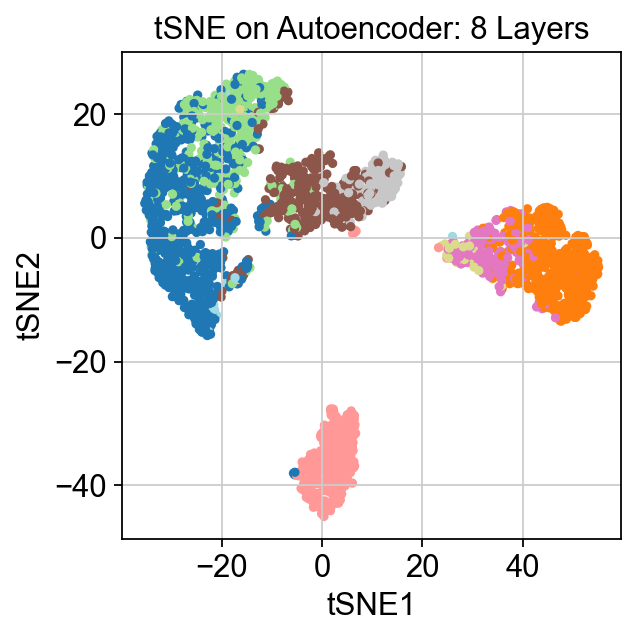

In [48]:
# TSNE ON PCA
model_tsne = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                  perplexity = 90, n_iter = 1000, verbose = 1)
tsne = model_tsne.fit_transform(x_train)
plt.scatter(tsne[:, 0], tsne[:, 1], c = y_train, cmap = 'tab20', s = 10)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()

# TSNE ON AUTOENCODER
model = Sequential()
model.add(Dense(10,     activation = 'elu', input_shape=(X.shape[1],)))
model.add(Dense(8,      activation = 'elu'))
model.add(Dense(6,      activation = 'elu'))
model.add(Dense(4,      activation = 'linear', name = "bottleneck"))
model.add(Dense(6,      activation = 'elu'))
model.add(Dense(8,      activation = 'elu'))
model.add(Dense(10,     activation = 'elu'))
model.add(Dense(X.shape[1],   activation = 'sigmoid'))
model.compile(loss = 'mean_squared_error', optimizer = Adam())
model.fit(X, X, batch_size = 128, epochs = 100, shuffle = True, verbose = 1)
encoder = Model(model.input, model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(X)

model_tsne_auto = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                       perplexity = 90, n_iter = 1000, verbose = 1)
tsne_auto = model_tsne_auto.fit_transform(bottleneck_representation)
plt.scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y, cmap = 'tab20', s = 10)
plt.title('tSNE on Autoencoder: 8 Layers')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()